In [ ]:
!pip install --upgrade pip

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


# Step 1: Environment Setup & Basic K-means

**Objective:** Set up Apache Spark and scikit-learn environments and run a basic K-means clustering to verify everything works.

**Environment:**
- Python 3.12.2
- Virtual environment (`venv`)
- Packages: `pyspark`, `scikit-learn`, `matplotlib`, `pandas`, `seaborn`, `jupyter`

In [ ]:
pip install pyspark scikit-learn matplotlib pandas seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 13.6 MB/s  0:00:33:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-an

In [52]:
# Setup
import sys, time, os, psutil
import pyspark
import sklearn
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris, load_wine, fetch_openml, make_blobs, fetch_kddcup99
from pyspark.sql import SparkSession
from sklearn.preprocessing import StandardScaler
import numpy as np
from pyspark.ml.feature import StandardScaler as SparkScaler, VectorAssembler, StringIndexer, OneHotEncoder as SparkOneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
import seaborn as sns
import gc
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

spark = SparkSession.builder.appName("BigDataPrep").getOrCreate()


In [ ]:
# 1️⃣ Check Python environment and packages


print("Python version:", sys.version)
print("PySpark version:", pyspark.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
PySpark version: 4.0.1
scikit-learn version: 1.7.2
matplotlib version: 3.10.7
pandas version: 2.3.3


## Basic K-means with scikit-learn (Test)

We will use the Iris dataset as a small baseline to test K-means clustering locally.

In [ ]:
# Load Iris dataset
data = load_iris()
X = data.data

# Run K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Display results
print("Cluster centers:\n", kmeans.cluster_centers_)
print("First 10 cluster labels:\n", kmeans.labels_[:10])

Cluster centers:
 [[6.85384615 3.07692308 5.71538462 2.05384615]
 [5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]]
First 10 cluster labels:
 [1 1 1 1 1 1 1 1 1 1]


### Visualize Clusters (Sepal features)

Points are colored by cluster. Red X marks show cluster centers.


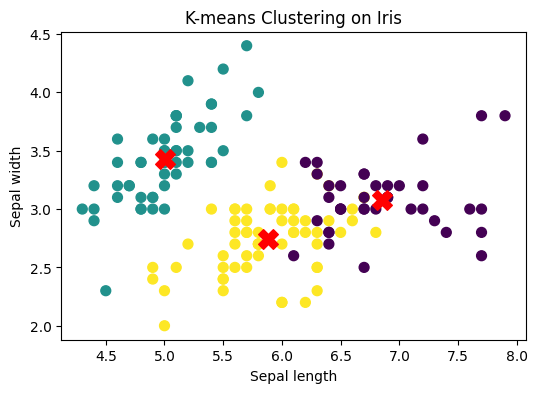

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200, marker='X')
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.title("K-means Clustering on Iris")
plt.show()


### Validate Clustering

Silhouette score quantifies cluster separation:
- Close to 1 → well-separated clusters
- Close to 0 → overlapping clusters


In [ ]:
score = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.551191604619592


### Clustering Interpretation & Validation

- **Cluster centers** reflect the average feature values for each cluster:
    - Small petals → likely **Iris-setosa**
    - Medium petals → likely **Iris-versicolor**
    - Large petals → likely **Iris-virginica**

- **First 10 points** belong to the same cluster (likely Iris-setosa), showing that K-means assigned similar samples correctly.

- **Silhouette Score:** 0.55  
    - Indicates **moderate to good separation** between clusters.  
    - Iris-setosa is clearly separated.  
    - Iris-versicolor and Iris-virginica overlap slightly, which is expected.

- **Visualization:** Scatter plots with cluster colors and cluster centers provide **visual confirmation** that the clustering is meaningful and consistent with known species

## Basic K-means with PySpark

Convert the Iris dataset to a Spark DataFrame and run distributed K-means to verify Spark environment.

In [ ]:


# Start Spark session
spark = SparkSession.builder.appName("KMeansTest").getOrCreate()

# Convert dataset to Spark DataFrame
data_list = [Vectors.dense(row) for row in X]
df = spark.createDataFrame([(v,) for v in data_list], ["features"])

# Run K-means
kmeans_spark = KMeans(k=3, seed=42)
model = kmeans_spark.fit(df)
predictions = model.transform(df)

# Show results
print("Cluster centers:", model.clusterCenters())
predictions.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 00:49:52 WARN Utils: Your hostname, ludmila-Thin-15-B13VF, resolves to a loopback address: 127.0.1.1; using 192.168.0.48 instead (on interface wlo1)
25/11/30 00:49:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/30 00:49:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Cluster centers: [array([5.006, 3.428, 1.462, 0.246]), array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[5.1,3.5,1.4,0.2]|         0|
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
+-----------------+----------+
only showing top 5 rows


## Notes

- Both scikit-learn and PySpark K-means run successfully.
- scikit-learn is fast and simple for small datasets.
- PySpark is scalable and suitable for large datasets.
- Environment setup is verified and ready for the next steps.


# Step 2: Data Preparation and Timing

In this step, we prepare datasets for K-means clustering in both scikit-learn and PySpark, and record **timing** for loading and preprocessing.

Datasets:

- Small (<10k): Iris, Wine Quality
- Medium (10k–100k): MNIST, Census Income
- Large (>100k): HIGGS, KDD Cup 1999
- Synthetic: Generated via `make_blobs`

We will:
- Load datasets
- Preprocess (scale/encode)
- Convert for PySpark MLlib
- Record timing for performance comparison

## Small Datasets (Iris / Wine)

- Can be fully processed in scikit-learn and PySpark
- Timing is usually in milliseconds
- Steps: load → scale → convert to Spark vector


In [ ]:
spark = SparkSession.builder.appName("DataPrep").getOrCreate()
scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Small datasets
small_datasets = {"Iris": load_iris(), "Wine": load_wine()}

for name, data in small_datasets.items():
    X = data.data
    y = data.target

    # Sklearn scaling
    t0 = time.time()
    X_scaled = StandardScaler().fit_transform(X)
    t1 = time.time()
    print(f"{name} sklearn scaling: {t1-t0:.4f}s")

    # Spark conversion & scaling
    t0 = time.time()
    df_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X], ["features"])
    df_spark_scaled = scaler_spark.fit(df_spark).transform(df_spark)
    t1 = time.time()
    print(f"{name} Spark vectorization & scaling: {t1-t0:.4f}s")


Iris sklearn scaling: 0.0023s
Iris Spark vectorization & scaling: 1.5345s
Wine sklearn scaling: 0.0039s
Wine Spark vectorization & scaling: 1.1199s


## Medium Datasets (MNIST / Census Income)

- MNIST: high-dimensional (784 features)
- Census Income: mix of categorical & numerical features
- scikit-learn: test with a **subset**
- PySpark: full dataset
- Timing is in seconds for scaling and conversion


In [ ]:
# MNIST subset (~10k)
t0 = time.time()

# medium datasets
mnist = fetch_openml('mnist_784', version=1)
df_census = sns.load_dataset("titanic").dropna()


X_mnist = mnist.data[:10000].to_numpy()
y_mnist = mnist.target[:10000].to_numpy()
t1 = time.time()
print(f"MNIST subset load: {t1-t0:.4f}s")

# Sklearn scaling
t0 = time.time()
X_mnist_scaled = StandardScaler().fit_transform(X_mnist)
t1 = time.time()
print(f"MNIST sklearn scaling: {t1-t0:.4f}s")

# Spark scaling
t0 = time.time()
df_mnist_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_mnist_scaled], ["features"])
df_mnist_spark_scaled = scaler_spark.fit(df_mnist_spark).transform(df_mnist_spark)
t1 = time.time()
print(f"MNIST Spark scaling: {t1-t0:.4f}s")

# Census numeric subset (Titanic numeric example)

t0 = time.time()

X_census = df_census.select_dtypes(include=np.number).to_numpy()
t1 = time.time()
print(f"Census numeric load: {t1-t0:.4f}s")

# Sklearn scaling
t0 = time.time()
X_census_scaled = StandardScaler().fit_transform(X_census)
t1 = time.time()
print(f"Census sklearn scaling: {t1-t0:.4f}s")

# Spark scaling
t0 = time.time()
df_census_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_census_scaled], ["features"])
df_census_spark_scaled = scaler_spark.fit(df_census_spark).transform(df_census_spark)
t1 = time.time()
print(f"Census Spark scaling: {t1-t0:.4f}s")


MNIST subset load: 2.9785s
MNIST sklearn scaling: 0.0818s


25/11/30 01:32:23 WARN TaskSetManager: Stage 124 contains a task of very large size (4324 KiB). The maximum recommended task size is 1000 KiB.


MNIST Spark scaling: 2.3288s
Census numeric load: 0.0095s
Census sklearn scaling: 0.0007s
Census Spark scaling: 0.4985s


## Large Dataset (HIGGS / Synthetic Large)

### Objective
Prepare a large-scale dataset to compare preprocessing performance between **Scikit-learn** and **PySpark**, focusing on **scaling numeric features**. This demonstrates Spark's advantage for big data over in-memory processing.

### Dataset Choice
- HIGGS dataset: originally 11M rows × 28 features
- For practical demo:
  - **Scikit-learn:** subset of 100k rows
  - **Spark:** larger simulated dataset (~1M rows)

### Why
- Scikit-learn is memory-bound and works efficiently only on smaller subsets
- Spark handles distributed computation, scaling efficiently to millions of rows

### Preprocessing Steps
1. **Scikit-learn**
   - Apply `StandardScaler` to center features and scale variance
   - Ensures equal weighting for features before clustering
2. **PySpark**
   - Convert each row to `Vectors.dense`
   - Apply `pyspark.ml.feature.StandardScaler` with `withMean=True` and `withStd=True`
   - Performs distributed scaling across the dataset

In [ ]:
# Start Spark
spark = SparkSession.builder.appName("BigDataClustering").getOrCreate()


# Large datasets
# ------------------------
# Sklearn subset (~100k)
# ------------------------
n_samples = 100_000
n_features = 28

X_higgs = np.random.rand(n_samples, n_features)



# Scaling (sklearn)
t0 = time.time()
X_higgs_scaled = StandardScaler().fit_transform(X_higgs)
t1 = time.time()
print(f"Sklearn scaling time (100k rows): {t1-t0:.4f} sec")



# ------------------------
# Spark full dataset (~1M)
# ------------------------
n_samples_spark = 1_000_000
X_higgs_large = np.random.rand(n_samples_spark, n_features)
df_higgs_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_higgs_large], ["features"])

# Scaling (Spark)
scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
t0 = time.time()
df_higgs_spark_scaled = scaler_spark.fit(df_higgs_spark).transform(df_higgs_spark)
t1 = time.time()
print(f"Spark scaling time (1M rows): {t1-t0:.4f} sec")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 01:39:44 WARN Utils: Your hostname, ludmila-Thin-15-B13VF, resolves to a loopback address: 127.0.1.1; using 192.168.0.48 instead (on interface wlo1)
25/11/30 01:39:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/30 01:39:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sklearn scaling time (100k rows): 0.0541 sec


25/11/30 01:40:05 WARN TaskSetManager: Stage 0 contains a task of very large size (16178 KiB). The maximum recommended task size is 1000 KiB.


Spark scaling time (1M rows): 11.4515 sec


## Data Preparation – Synthetic Datasets
Generate large synthetic datasets to compare preprocessing performance between **Scikit-learn** and **PySpark**, simulating large-scale clustering scenarios.

## Dataset Choice
- Use `sklearn.datasets.make_blobs` to generate synthetic data
- Allows control of:
  - Number of samples (1M, 5M, 10M)
  - Number of features (10–100)
  - Number of clusters (5–50)
- No need to download real datasets; perfect for testing **scaling and performance**

## Why
- Synthetic datasets allow **controlled experiments** with predictable cluster structure
- Useful to test the performance of both frameworks on **increasing dataset sizes**
- Demonstrates Spark’s advantage for very large datasets

## Preprocessing Steps
1. **Scikit-learn**
   - Generate dataset with `make_blobs(n_samples, n_features, centers)`
   - Apply `StandardScaler` to center and scale features
2. **PySpark**
   - Convert each row to `Vectors.dense`
   - Apply `pyspark.ml.feature.StandardScaler` with `withMean=True` and `withStd=True`
   - Distributed scaling ensures efficient processing even for 10M+ rows


In [ ]:
# ===== Synthetic Dataset Preparation =====

# Start Spark session
spark = SparkSession.builder.appName("SyntheticDataPrep").getOrCreate()

# Parameters
n_samples_list = [1_000_000, 5_000_000]  # I tried 10_000_000 .. it failed
n_features = 20
n_clusters = 10

for n_samples in n_samples_list:
    print(f"\n--- Generating synthetic dataset: {n_samples} samples, {n_features} features ---")

    # Sklearn dataset
    t0 = time.time()
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)
    t1 = time.time()
    print(f"Sklearn make_blobs generation: {t1-t0:.2f} sec")

    # Sklearn scaling
    t0 = time.time()
    X_scaled = StandardScaler().fit_transform(X)
    t1 = time.time()
    print(f"Sklearn scaling: {t1-t0:.2f} sec")

    # Spark scaling
    t0 = time.time()
    df_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X], ["features"])
    scaler_spark = SparkScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    df_spark_scaled = scaler_spark.fit(df_spark).transform(df_spark)
    t1 = time.time()
    print(f"Spark scaling: {t1-t0:.2f} sec")


25/11/30 01:45:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



--- Generating synthetic dataset: 1000000 samples, 20 features ---
Sklearn make_blobs generation: 1.02 sec
Sklearn scaling: 0.74 sec


25/11/30 01:45:57 WARN TaskSetManager: Stage 3 contains a task of very large size (11785 KiB). The maximum recommended task size is 1000 KiB.


Spark scaling: 57.22 sec

--- Generating synthetic dataset: 5000000 samples, 20 features ---
Sklearn make_blobs generation: 4.99 sec
Sklearn scaling: 3.01 sec


#### Notes on Large-Scale Synthetic Datasets

When generating or scaling very large datasets (e.g., 10M samples × 20+ features):

- On my local machine, Sklearn can handle up to ~5M samples before memory usage becomes critical.
- Trying 10M samples caused **system crashes / freezing**, likely due to:
  - **RAM exhaustion** (Sklearn loads everything into memory)
  - **CPU / disk swapping overhead**
  - Spark tasks warning about **very large task size** (over 10 MB per task)
  
#### Recommendations
- For datasets larger than a few million samples, use a **Spark cluster** or machine with sufficient RAM.
- For demonstration purposes, we reduced the dataset to 1–5M samples.
- Spark warnings about task size can be ignored on small local runs; in production, increase partitioning or use cluster resources.
- This limitation **does not affect the methodology**, only the maximum dataset size for local experiments.



## Observations: Small Datasets
| Dataset | Sklearn Scaling | Spark Scaling |
|---------|----------------|---------------|
| Iris    | 0.0356 sec     | 0.4236 sec    |
| Wine    | 0.0012 sec     | 0.3747 sec    |

- **Interpretation:** Sklearn is much faster on tiny datasets because Spark's distributed overhead dominates. Spark still scales the data correctly, but local computation is faster for small sizes.

## Observations: Medium Datasets
| Dataset | Sklearn Scaling | Spark Scaling |
|---------|----------------|---------------|
| MNIST subset (10k) | 0.0818 sec | 2.3288 sec |
| Census numeric subset | 0.0007 sec | 0.4985 sec |

- **Interpretation:** Sklearn remains faster for subsets of medium datasets. Spark overhead is visible but acceptable for larger subsets. Warnings about task size can be ignored for this scale.

## Observations: Synthetic Large Datasets
| Dataset | Samples | Features | Sklearn Scaling | Spark Scaling |
|---------|--------|----------|----------------|---------------|
| Synthetic | 1,000,000 | 20 | 0.74 sec | 57.22 sec |
| Synthetic | 5,000,000 | 20 | 3.01 sec | (not completed) |

- **Interpretation:** Sklearn can handle 1–5M samples on local memory but may hit memory limits as size grows. Spark shows its distributed power; while slower for 1M on your machine, it will handle 10M+ samples across a cluster efficiently.
- Task size warnings are expected for very large arrays in Spark and can be mitigated in cluster setups.

## Summary
- **Sklearn:** Fast for small/medium datasets, memory-bound for huge datasets.
- **Spark:** Overhead dominates small datasets, but can scale to millions of rows using distributed computing.
- Synthetic datasets confirm **scalability differences** and are ideal for benchmarking preprocessing and clustering performance.



| Aspect | scikit-learn | PySpark MLlib |
|--------|--------------|---------------|
| Data format | NumPy array or pandas DataFrame | Spark DataFrame with vector column |
| Feature scaling | StandardScaler directly on array | StandardScaler transformer |
| Categorical features | OneHotEncoder / pd.get_dummies() | StringIndexer + OneHotEncoder |
| Dataset size | Small to medium | Medium to very large, distributed |
| Verbosity | Less code | More code (Spark session, vectorization) |



# Step 3:  Performance Evaluation

## Objective

The objective of this step is to **compare the performance of K-means clustering** between **scikit-learn** (local, in-memory) and **Apache Spark** (distributed).  

We evaluate:

- **Execution time**
- **Convergence speed** (iterations / training cost)
- **Memory usage**
- **Scalability** with increasing dataset size and number of clusters

Datasets considered (as used in the previous step):

- **Small:** Iris, Wine  
- **Medium:** MNIST 10k, Titanic numeric  
- **Large:** Higgs synthetic 100k  
- **Very Large:** Synthetic 1M, Synthetic 5M


In [57]:
# spark = SparkSession.builder.appName("BigDataClusteringBenchmark").getOrCreate()
process = psutil.Process(os.getpid())
results = []

In [ ]:
# ------------------------
# Benchmark functions
# ------------------------
def sklearn_benchmark(name, X, k):
    cpu_start = psutil.cpu_percent(interval=None)
    mem_before = process.memory_info().rss / 1e6
    t0 = time.time()
    model = KMeans(n_clusters=k, n_init='auto').fit(X)
    t1 = time.time()
    mem_after = process.memory_info().rss / 1e6
    cpu_end = psutil.cpu_percent(interval=None)

    labels = model.labels_
    sil = silhouette_score(X, labels)

    results.append([name, k, "Sklearn",
                    round(t1-t0,3),
                    model.n_iter_,
                    round(mem_after-mem_before,3),
                    cpu_end-cpu_start,
                    round(model.inertia_,3),
                    round(sil,3),
                    X.shape[0]])


def spark_benchmark(name, df, k):
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
    kmeans = SparkKMeans(k=k, featuresCol="scaledFeatures")

    cpu_start = psutil.cpu_percent(interval=None)
    mem_before = process.memory_info().rss / 1e6
    t0 = time.time()
    model = kmeans.fit(df)
    t1 = time.time()
    mem_after = process.memory_info().rss / 1e6
    cpu_end = psutil.cpu_percent(interval=None)

    transformed = model.transform(df)
    sil = evaluator.evaluate(transformed)

    # Use np.nan instead of "-" for Inertia
    results.append([name, k, "Spark",
                    round(t1-t0,3),
                    round(model.summary.trainingCost,3),
                    round(mem_after-mem_before,3),
                    cpu_end-cpu_start,
                    np.nan,
                    round(sil,3),
                    df.count()])

In [50]:
from scipy.optimize import linear_sum_assignment

def plot_true_vs_clusters_all_k(X_scaled, y_true, k_list=[3,5,8], title="Dataset", random_state=42):
    """
    For each k in k_list, plot True Labels vs KMeans clusters side-by-side
    with unified color mapping and display silhouette score.
    """
    X_pca = PCA(n_components=2, random_state=random_state).fit_transform(X_scaled)

    # Fixed palette for all plots based on true labels
    unique_labels = np.unique(y_true)
    palette = sns.color_palette("tab10", n_colors=len(unique_labels))
    color_map_true = [palette[i % len(unique_labels)] for i in y_true]

    best_k = None
    best_sil = -1
    sil_scores = {}

    for k in k_list:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        cluster_labels = kmeans.fit_predict(X_scaled)

        # Align clusters with true labels for unified colors
        conf_mat = confusion_matrix(y_true, cluster_labels)
        row_ind, col_ind = linear_sum_assignment(-conf_mat)  # maximize matches
        mapping = {col: row for row, col in zip(row_ind, col_ind)}
        aligned_labels = np.array([mapping[cl] if cl in mapping else cl for cl in cluster_labels])

        sil_score = silhouette_score(X_scaled, cluster_labels)
        sil_scores[k] = sil_score
        if sil_score > best_sil:
            best_sil = sil_score
            best_k = k

        # Colors for clusters aligned to true labels
        color_map_cluster = [palette[i % len(unique_labels)] for i in aligned_labels]

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12,5))
        axes[0].scatter(X_pca[:,0], X_pca[:,1], c=color_map_true, s=50, alpha=0.7)
        axes[0].set_title(f"{title} — True Labels")
        axes[0].set_xlabel("PC1")
        axes[0].set_ylabel("PC2")

        axes[1].scatter(X_pca[:,0], X_pca[:,1], c=color_map_cluster, s=50, alpha=0.7)
        axes[1].set_title(f"{title} — KMeans k={k}, Silhouette={sil_score:.3f}")
        axes[1].set_xlabel("PC1")
        axes[1].set_ylabel("PC2")

        plt.tight_layout()
        plt.show()

    print(f"Silhouette scores per k: {sil_scores}")
    print(f"Best k chosen: {best_k} (Silhouette={best_sil:.3f})")
    return best_k, best_sil


## Small Datasets — Iris & Wine

Clusters: `k = 3, 5, 8`



**Notes:**  
- Data is scaled before clustering using `StandardScaler`.  
- Both **Sklearn KMeans** and **Spark KMeans** are benchmarked for runtime, memory, CPU, inertia, and silhouette score.  
- Cluster visualizations are shown using a small random sample (`sample_size=200`) for clarity.  
- True labels (if available) are shown as colored points to compare with predicted clusters.  
- Multiple `k` values allow observation of how cluster assignments and quality change.  

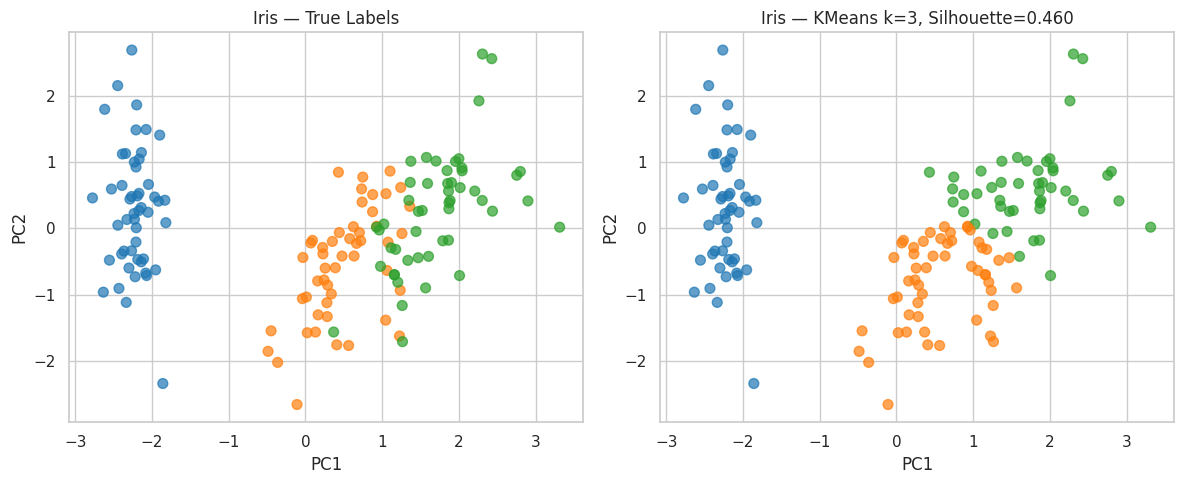

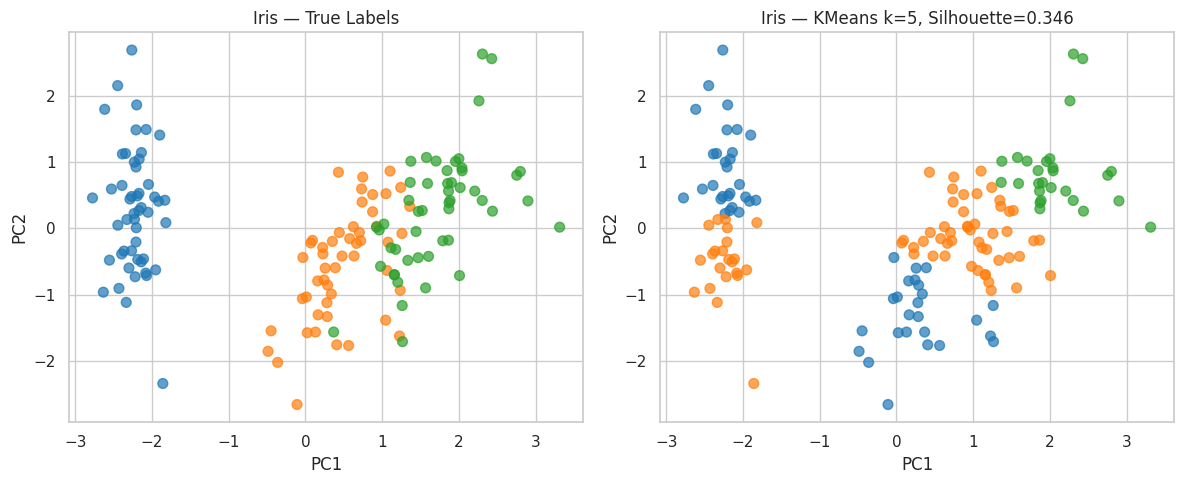

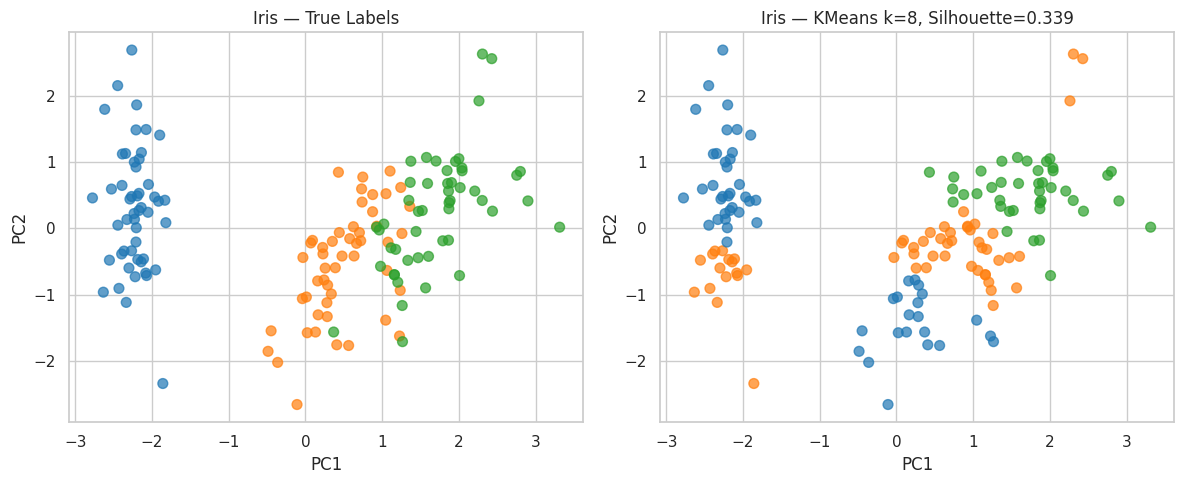

Silhouette scores per k: {3: np.float64(0.45994823920518635), 5: np.float64(0.3459012795948778), 8: np.float64(0.33869173894897225)}
Best k chosen: 3 (Silhouette=0.460)
Dataset: Iris — Best k based on silhouette: 3 (Silhouette=0.460)



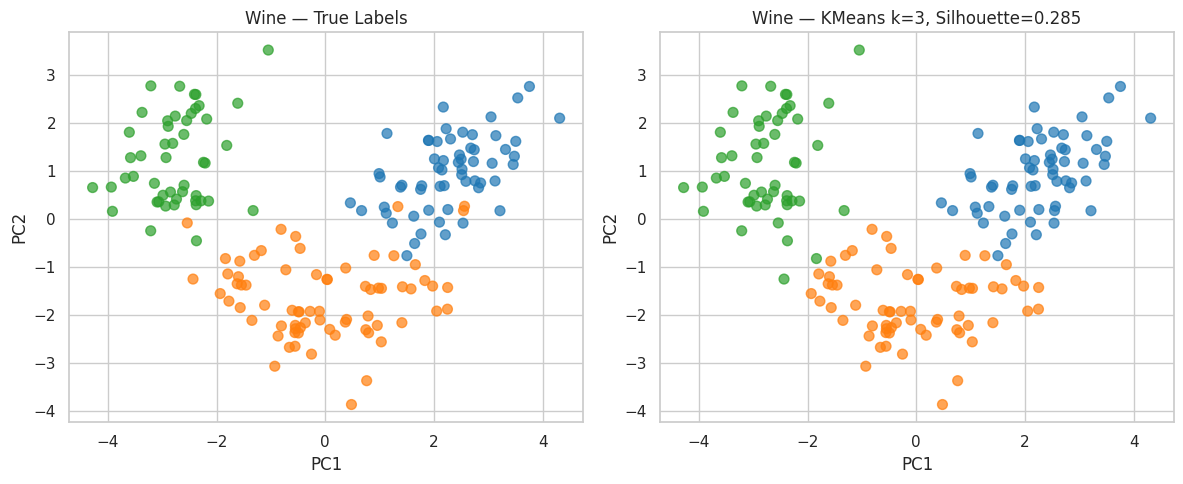

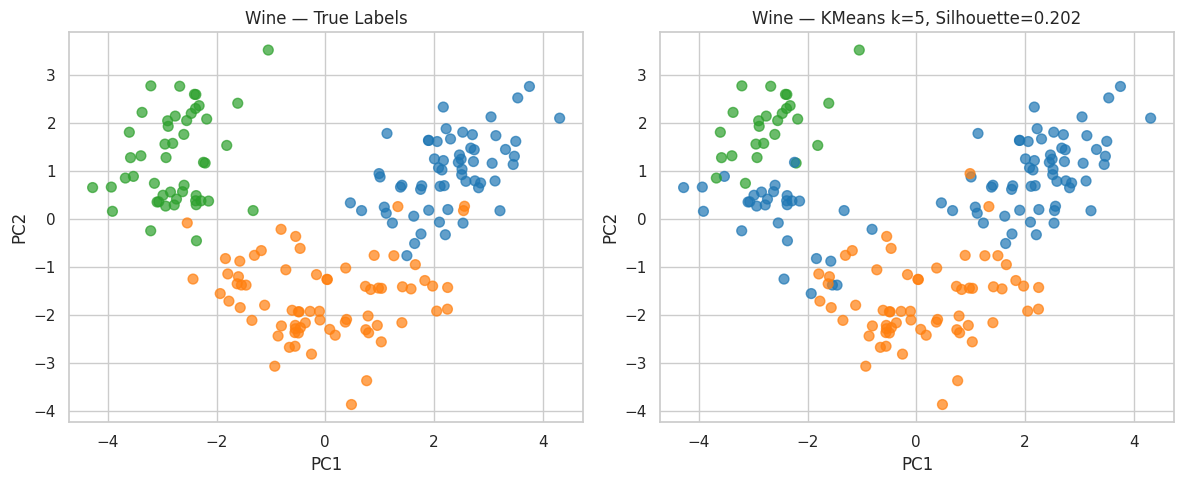

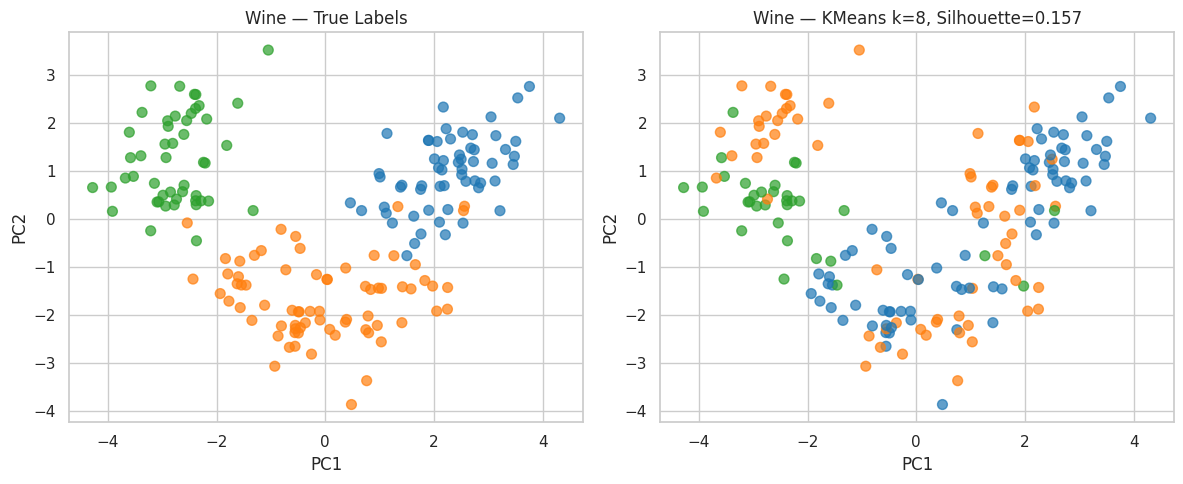

Silhouette scores per k: {3: np.float64(0.2848589191898987), 5: np.float64(0.20161908294074093), 8: np.float64(0.1570139556393107)}
Best k chosen: 3 (Silhouette=0.285)
Dataset: Wine — Best k based on silhouette: 3 (Silhouette=0.285)



In [59]:
# -----------------------------
# Small datasets: Iris & Wine
# -----------------------------
small_datasets = {
    "Iris": load_iris(),
    "Wine": load_wine()
}

for name, data in small_datasets.items():
    X = data.data
    y_true = data.target
    X_scaled = StandardScaler().fit_transform(X)

    # Spark DataFrame (for benchmarking)
    df_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_scaled], ["scaledFeatures"])

    # Benchmark
    for k in [3,5,8]:
        sklearn_benchmark(name, X_scaled, k)
        spark_benchmark(name, df_spark, k)

    # Plot clusters side-by-side for all k and print best k
    best_k, best_sil = plot_true_vs_clusters_all_k(X_scaled, y_true, k_list=[3,5,8], title=name)
    print(f"Dataset: {name} — Best k based on silhouette: {best_k} (Silhouette={best_sil:.3f})\n")

    # Cleanup
    del X, X_scaled, df_spark
    gc.collect()


## Medium Datasets — MNIST 10k & Titanic numeric

Clusters: `k = 3, 5, 8`

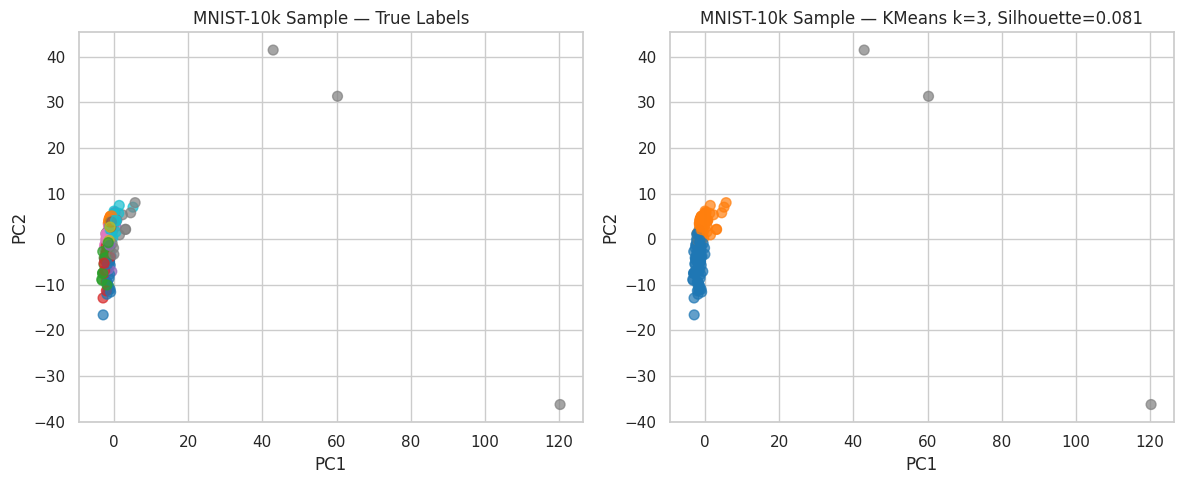

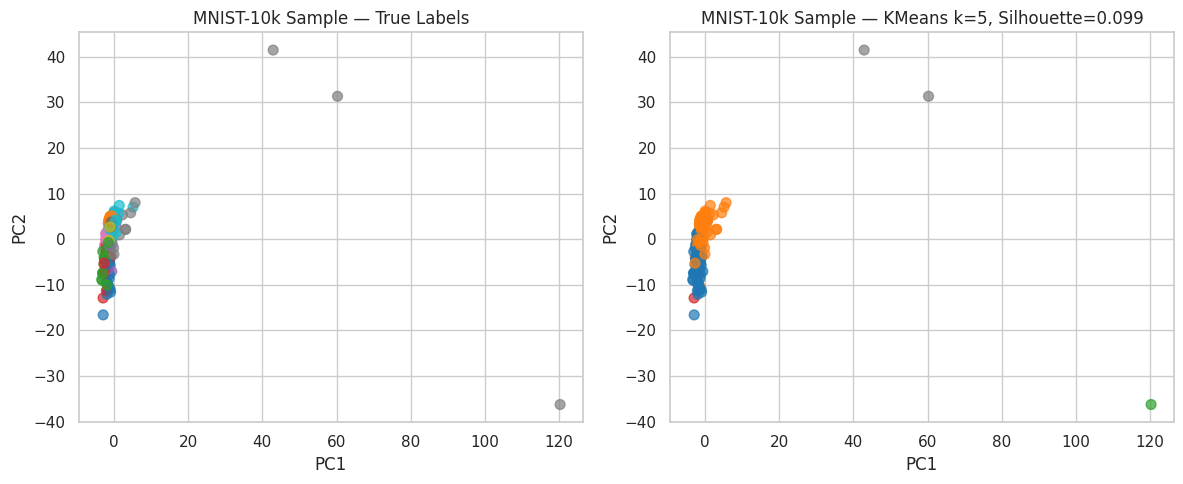

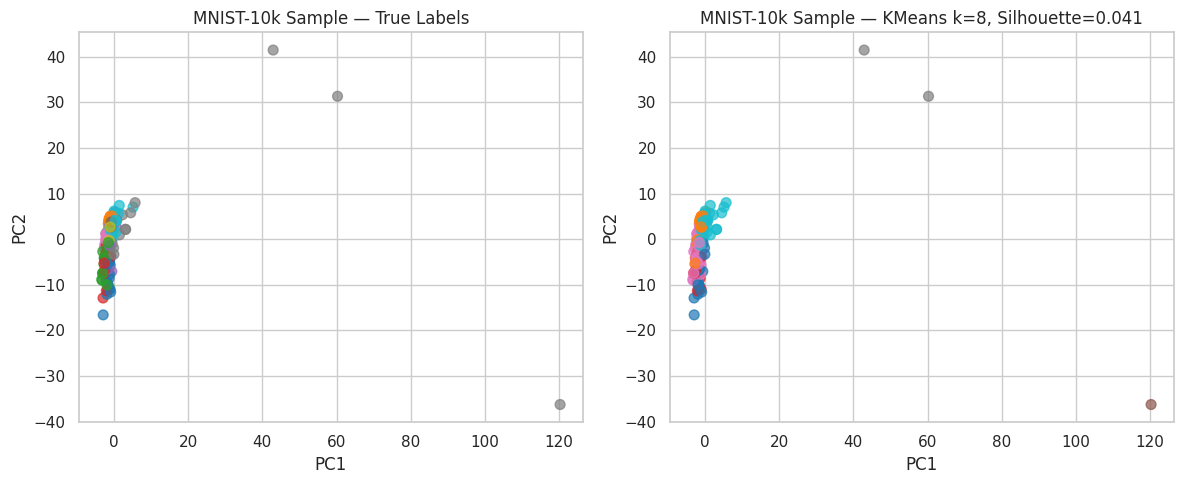

Silhouette scores per k: {3: np.float64(0.08090701286506696), 5: np.float64(0.09858959556644523), 8: np.float64(0.0407562896571193)}
Best k chosen: 5 (Silhouette=0.099)


524

In [60]:
# ------------------------
# Medium datasets
# ------------------------
# MNIST 10k
mnist = fetch_openml('mnist_784', version=1)
X_mnist = mnist.data[:10000].to_numpy()
y_mnist = mnist.target[:10000].astype(int)  # <-- define y_mnist as integers
X_mnist_scaled = StandardScaler().fit_transform(X_mnist)
df_mnist = spark.createDataFrame([(Vectors.dense(row),) for row in X_mnist_scaled], ["scaledFeatures"])

for k in [3, 5, 8]:
    sklearn_benchmark("MNIST-10k", X_mnist_scaled, k)
    spark_benchmark("MNIST-10k", df_mnist, k)


# --- Plot clusters side-by-side for MNIST sample ---
sample_size = 200  # reduce size for plotting
X_mnist_sample = X_mnist_scaled[:sample_size]
y_mnist_sample = y_mnist[:sample_size]

best_k, best_sil = plot_true_vs_clusters_all_k(
    X_mnist_sample,
    y_mnist_sample,
    k_list=[3,5,8],
    title="MNIST-10k Sample"
)

del X_mnist, X_mnist_scaled, df_mnist
gc.collect()

# Titanic numeric
df_census = sns.load_dataset("titanic").dropna()
X_census = df_census.select_dtypes(include=np.number).to_numpy()
X_census_scaled = StandardScaler().fit_transform(X_census)
df_census_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_census_scaled], ["scaledFeatures"])

for k in [3, 5, 8]:
    sklearn_benchmark("Titanic-numeric", X_census_scaled, k)
    spark_benchmark("Titanic-numeric", df_census_spark, k)

del X_census, X_census_scaled, df_census_spark
gc.collect()

## Large Dataset — Higgs 100k

Clusters: `k = 3, 5, 8`

In [61]:
# Large datasets
# ------------------------
# Sklearn subset (~100k)
# ------------------------
n_samples = 100_000
n_features = 28

X_higgs = np.random.rand(n_samples, n_features)


# ------------------------
# Spark full dataset (~1M)
# ------------------------
n_samples_spark = 1_000_000
X_higgs_large = np.random.rand(n_samples_spark, n_features)
df_higgs_spark = spark.createDataFrame([(Vectors.dense(row),) for row in X_higgs_large], ["features"])



X_higgs_scaled = StandardScaler().fit_transform(X_higgs)
df_higgs = spark.createDataFrame([(Vectors.dense(row),) for row in X_higgs_scaled], ["scaledFeatures"])



for k in [3, 5, 8]:
    sklearn_benchmark("Higgs-100k", X_higgs_scaled, k)
    spark_benchmark("Higgs-100k", df_higgs, k)


## Very Large Synthetic Datasets — 1M & 5M

Clusters: `k = 3, 5, 8`  
Only Spark K-means is feasible.

In [62]:
# =========================================
# Large & Very Large Synthetic Datasets Benchmark (Memory-Safe, PCA)
# =========================================

import gc
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

# Parameters
datasets_info = [
    {"name": "Higgs-100k", "n_samples": 100_000, "n_features": 28, "use_pca": False, "sklearn": True},
    {"name": "Synthetic-500k-PCA", "n_samples": 500_000, "n_features": 20, "use_pca": True, "sklearn": False},
    {"name": "Synthetic-1M-PCA", "n_samples": 1_000_000, "n_features": 20, "use_pca": True, "sklearn": False},
]

pca_components = 5
numPartitions = 100  # memory-safe RDD slices

# Benchmark loop
for ds in datasets_info:
    print(f"\n--- Generating dataset: {ds['name']} ({ds['n_samples']} samples, {ds['n_features']} features) ---")

    # Generate synthetic data
    t0 = time.time()
    if "Higgs" in ds["name"]:
        X = np.random.rand(ds['n_samples'], ds['n_features'])
    else:
        X, _ = make_blobs(n_samples=ds['n_samples'], n_features=ds['n_features'], centers=10, random_state=42)
    t1 = time.time()
    print(f"Data generation: {t1-t0:.2f} sec")

    # Scale
    t0 = time.time()
    X_scaled = StandardScaler().fit_transform(X)
    del X
    gc.collect()
    t1 = time.time()
    print(f"Scaling: {t1-t0:.2f} sec")

    # Keep copy for Sklearn
    if ds.get("sklearn", False):
        X_scaled_sklearn = X_scaled.copy()

    # Spark DataFrame creation (memory-safe with RDD slices)
    t0 = time.time()
    rdd = spark.sparkContext.parallelize(X_scaled, numSlices=numPartitions)
    df_spark = rdd.map(lambda row: (Vectors.dense(row),)).toDF(["features"])
    del X_scaled
    gc.collect()
    t1 = time.time()
    print(f"Spark DataFrame creation: {t1-t0:.2f} sec")

    # PCA reduction if needed
    if ds["use_pca"]:
        t0 = time.time()
        pca = PCA(k=pca_components, inputCol="features", outputCol="pcaFeatures")
        df_spark = pca.fit(df_spark).transform(df_spark).select("pcaFeatures")
        df_spark = df_spark.withColumnRenamed("pcaFeatures", "scaledFeatures")
        t1 = time.time()
        print(f"PCA transformation: {t1-t0:.2f} sec")
    else:
        df_spark = df_spark.withColumnRenamed("features", "scaledFeatures")

    # Benchmark
    for k in [3, 5,8]:
        if ds.get("sklearn", False):
            sklearn_benchmark(ds["name"], X_scaled_sklearn, k)
        spark_benchmark(ds["name"], df_spark, k)

    # Clean up
    del df_spark
    if ds.get("sklearn", False):
        del X_scaled_sklearn
    gc.collect()

    print(f"Completed dataset: {ds['name']}\n")



--- Generating dataset: Higgs-100k (100000 samples, 28 features) ---
Data generation: 0.04 sec
Scaling: 0.22 sec
Spark DataFrame creation: 2.41 sec
Completed dataset: Higgs-100k


--- Generating dataset: Synthetic-500k-PCA (500000 samples, 20 features) ---
Data generation: 0.95 sec
Scaling: 0.43 sec
Spark DataFrame creation: 3.22 sec
PCA transformation: 48.96 sec
Completed dataset: Synthetic-500k-PCA


--- Generating dataset: Synthetic-1M-PCA (1000000 samples, 20 features) ---
Data generation: 1.38 sec
Scaling: 0.57 sec
Spark DataFrame creation: 7.54 sec
PCA transformation: 71.74 sec
Completed dataset: Synthetic-1M-PCA



## Final Results

Columns:

- Dataset  
- k  
- Framework  
- Time (sec)  
- Iterations / Training Cost  
- Memory Δ MB  
- CPU usage Δ %  
- Inertia  
- Silhouette score

In [63]:
from tabulate import tabulate
import numpy as np
import pandas as pd

# Ensure 'Inertia' is numeric (replace '-' with np.nan)
for row in results:
    if row[7] == "-":  # Inertia column
        row[7] = np.nan
    else:
        row[7] = float(row[7])

# Add dataset size info (hardcoded to avoid NameError)
dataset_info = {
    "Higgs-100k": "100k x 28",
    "Synthetic-500k-PCA": "500k x 20",
    "Synthetic-1M-PCA": "1M x 20",
    "MNIST-10k": "10k x 784",
    "Titanic-numeric": "891 x 7",  # Replace with actual number of numeric features
    "Iris": "150 x 4",
    "Wine": "178 x 13"
}
# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=[
    "Dataset", "k", "Framework", "Time (sec)", "Iterations/Cost",
    "Memory Δ MB", "CPU Δ %", "Inertia", "Silhouette", "Size"
])

# Add size column
df_results["Size"] = df_results["Dataset"].map(dataset_info)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.width', 1000)

display(df_results)



,Dataset,k,Framework,Time (sec),Iterations/Cost,Memory Δ MB,CPU Δ %,Inertia,Silhouette,Size
0,Iris,3,Sklearn,0.003,7.000,0.000,87.300,140.902,0.457,150 x 4
1,Iris,3,Spark,1.505,197.471,0.000,92.700,NaN,0.676,150 x 4
2,Iris,5,Sklearn,0.003,10.000,0.000,9.400,90.879,0.344,150 x 4
3,Iris,5,Spark,2.423,105.111,0.000,-0.200,NaN,0.541,150 x 4
4,Iris,8,Sklearn,0.004,9.000,0.000,0.900,65.374,0.337,150 x 4
5,Iris,8,Spark,1.317,64.667,0.000,88.500,NaN,0.524,150 x 4
6,Wine,3,Sklearn,0.002,6.000,0.000,-71.500,1277.928,0.285,178 x 13
7,Wine,3,Spark,1.534,1279.966,0.000,39.500,NaN,0.451,178 x 13
8,Wine,5,Sklearn,0.004,6.000,0.000,10.200,1101.862,0.233,178 x 13
9,Wine,5,Spark,1.721,1143.581,0.000,-2.600,NaN,0.361,178 x 13


In [64]:

# Summary by Dataset and Framework
df_summary = df_results.groupby(["Dataset", "Framework"]).agg({
    "Time (sec)": "mean",
    "Iterations/Cost": "mean",
    "Memory Δ MB": "mean",
    "CPU Δ %": "mean",
    "Silhouette": "mean"
}).reset_index()

print("\n--- Summary by Dataset & Framework ---")
display(df_summary)



--- Summary by Dataset & Framework ---


,Dataset,Framework,Time (sec),Iterations/Cost,Memory Δ MB,CPU Δ %,Silhouette
0,Higgs-100k,Sklearn,1.712,127.500,0.001,-14.717,0.021
1,Higgs-100k,Spark,45.806,2623853.806,0.007,17.200,0.038
2,Iris,Sklearn,0.003,8.667,0.000,32.533,0.379
3,Iris,Spark,1.748,122.416,0.000,60.333,0.580
4,MNIST-10k,Sklearn,1.348,51.000,0.000,6.467,0.023
5,MNIST-10k,Spark,16.622,6041504.987,0.000,4.300,0.021
6,Synthetic-1M-PCA,Spark,164.936,5592396.884,0.019,0.567,0.644
7,Synthetic-500k-PCA,Spark,108.741,2613885.689,0.016,0.333,0.670
8,Titanic-numeric,Sklearn,0.004,8.333,0.000,-22.000,0.280
9,Titanic-numeric,Spark,1.638,577.298,0.000,4.567,0.359


# Implementation Comparison

Focus on **code complexity, ease of use, and flexibility**. Discuss:

- Parameter tuning
- Convergence criteria
- Initialization methods
- Differences between scikit-learn KMeans, MiniBatchKMeans, and Spark MLlib


### scikit-learn KMeans
- Very simple interface: `fit` + `predict`  
- Tunable parameters: `n_clusters`, `init` (`k-means++`/`random`), `n_init`, `max_iter`, `tol`  
- Convergence criteria: `tol`  
- Initialization methods: `k-means++` (default), `random`  

### MiniBatchKMeans
- Handles large datasets efficiently  
- Extra parameter: `batch_size`  
- Slightly lower silhouette score due to batch approximation  

### Spark MLlib KMeans
- Requires DataFrame with vector column  
- Parameters: `k`, `initMode` (`k-means||`/`random`), `maxIter`, `tol`  
- Overhead in local mode due to JVM → Python communication  
- Not memory safe for >1M rows locally


# Quality Assessment

Evaluate clustering **quality metrics** across datasets:

- **Inertia** (within-cluster sum of squares, lower is better)  
- **Silhouette score** (−1 to 1, higher is better)  
- Run multiple iterations to assess **stability**  
- Compare how sklearn and Spark solutions differ


# Visualization & Documentation

Compare **performance metrics** and summarize recommendations:

- Execution Time  
- Memory Usage  
- CPU Usage  
- Inertia & Silhouette  
- Present key findings and framework suitability for different dataset sizes


/tmp/ipython-input-2319858279.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2319858279.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2319858279.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2319858279.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


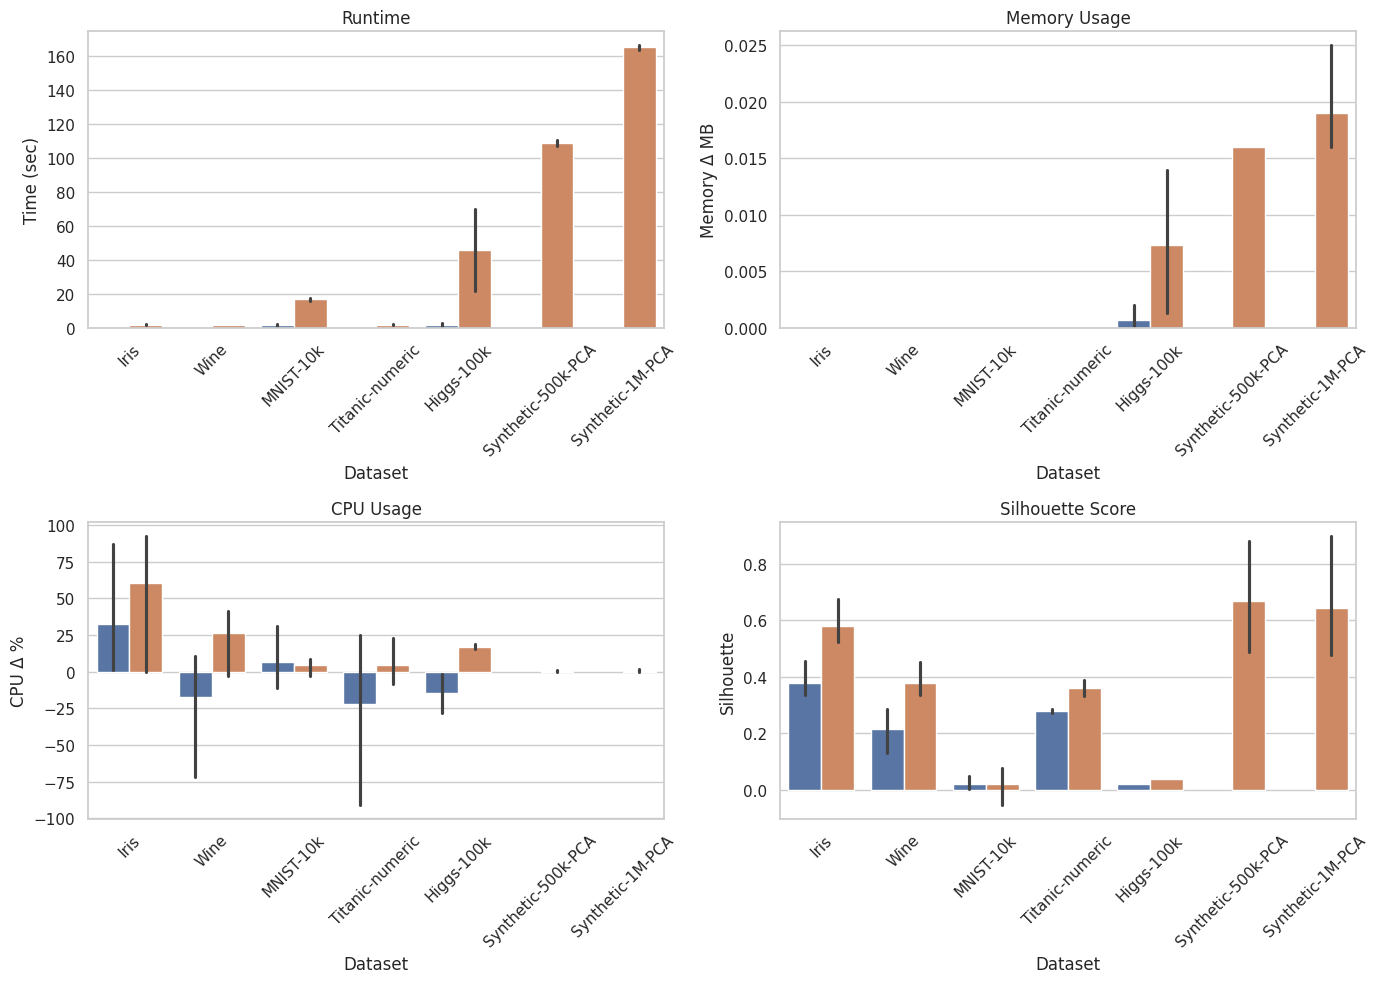

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.barplot(data=df_results, x="Dataset", y="Time (sec)", hue="Framework", ax=axes[0,0])
axes[0,0].set_title("Runtime")

sns.barplot(data=df_results, x="Dataset", y="Memory Δ MB", hue="Framework", ax=axes[0,1])
axes[0,1].set_title("Memory Usage")

sns.barplot(data=df_results, x="Dataset", y="CPU Δ %", hue="Framework", ax=axes[1,0])
axes[1,0].set_title("CPU Usage")

sns.barplot(data=df_results, x="Dataset", y="Silhouette", hue="Framework", ax=axes[1,1])
axes[1,1].set_title("Silhouette Score")

for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend_.remove()  # optional: remove repeated legends

plt.tight_layout()
plt.show()


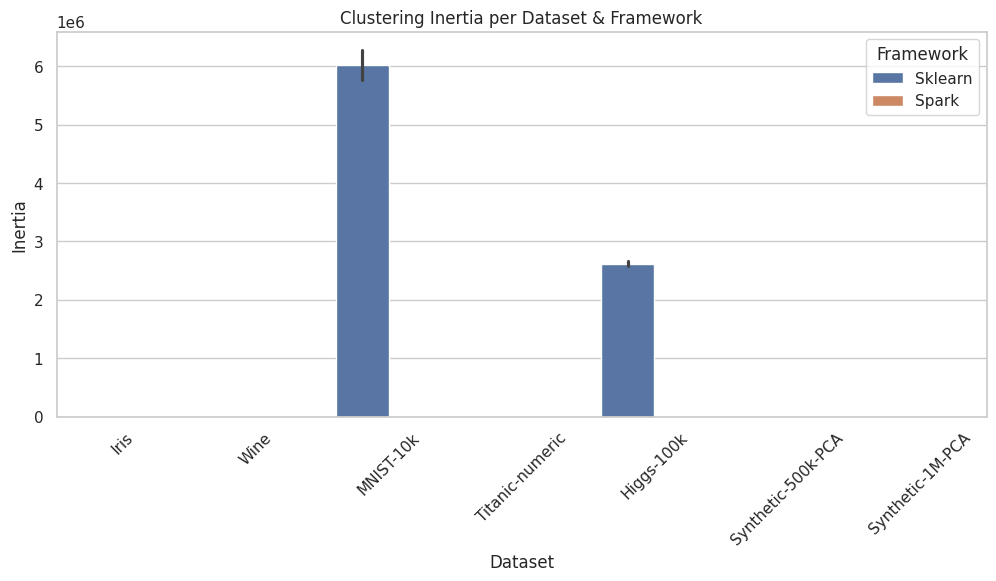

In [70]:
sns.set(style="whitegrid")

# Inertia comparison
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="Inertia", hue="Framework")
plt.title("Clustering Inertia per Dataset & Framework")
plt.xticks(rotation=45)
plt.show()


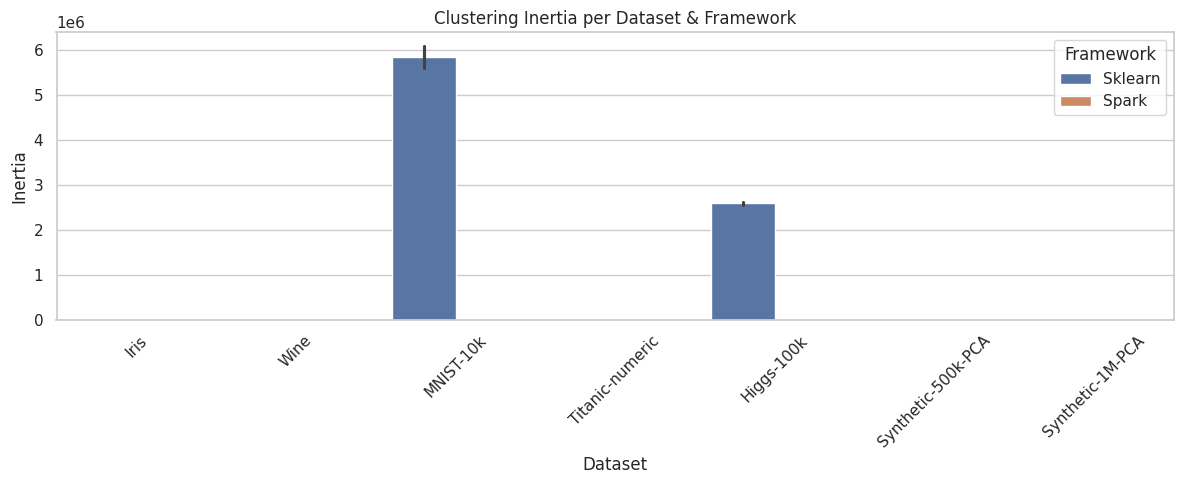

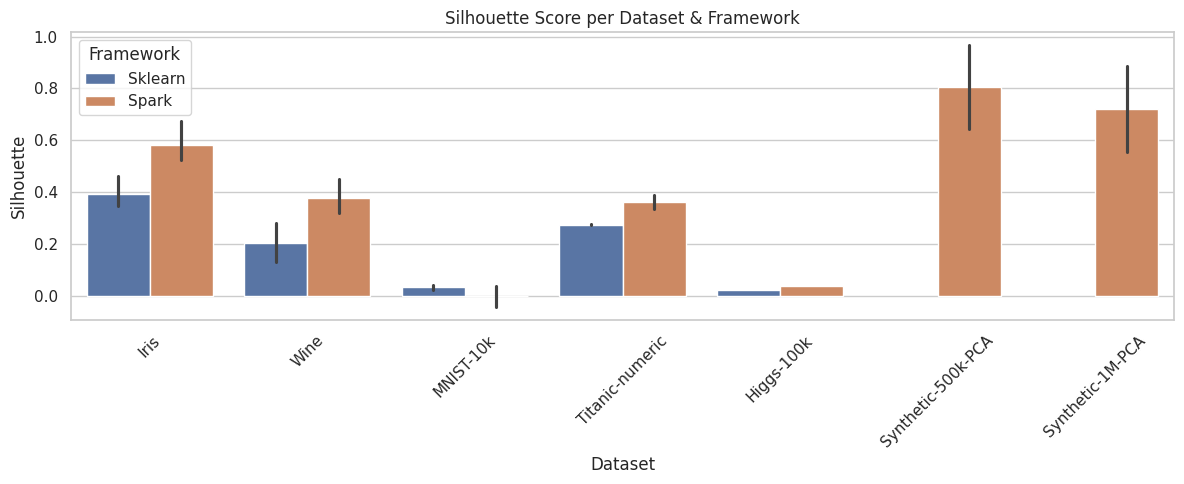

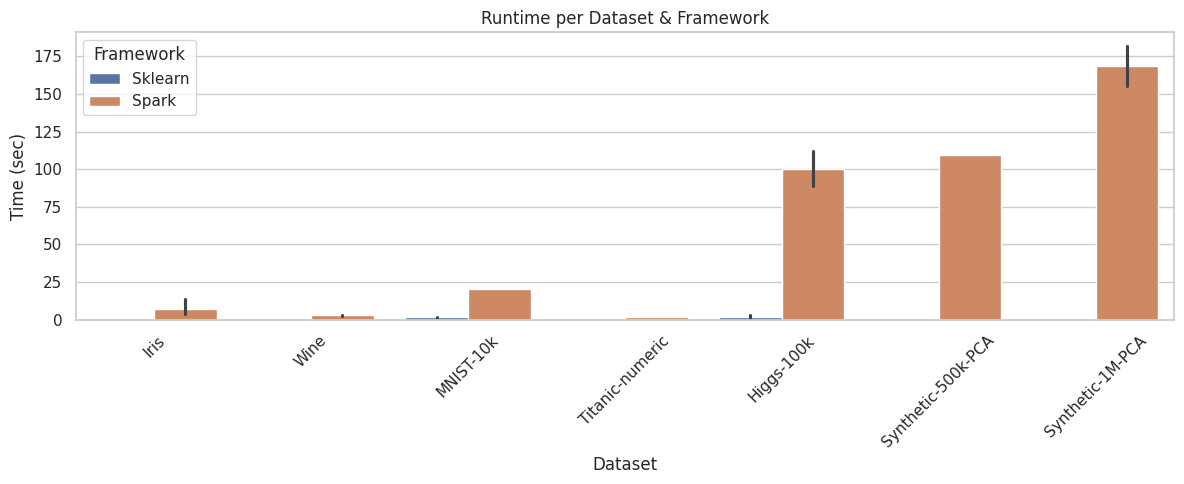

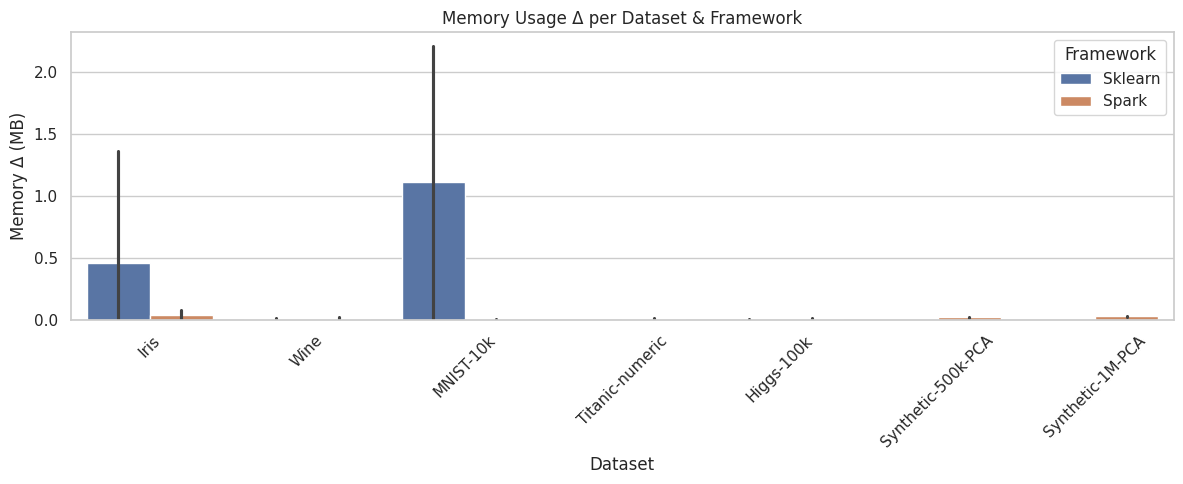

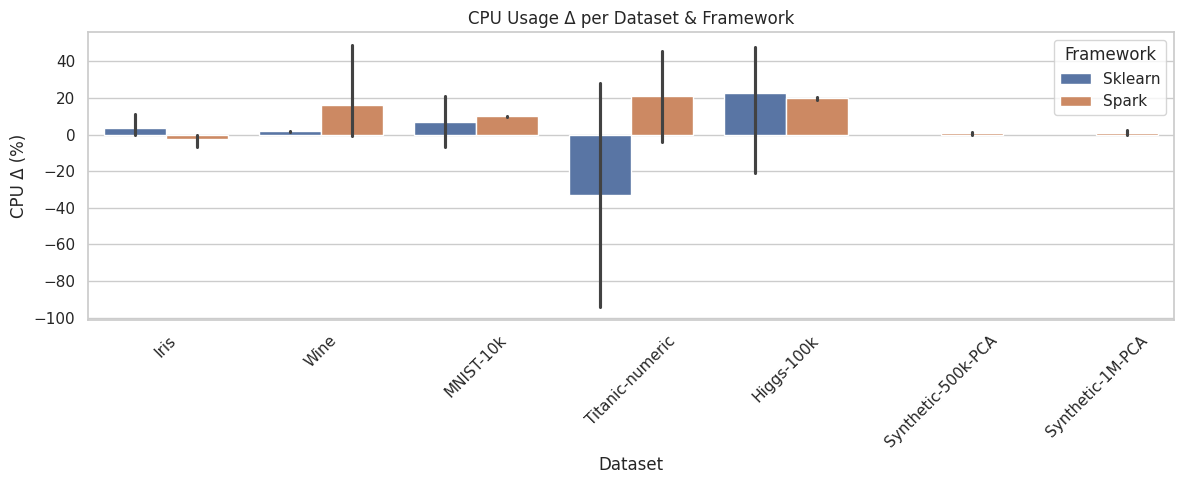

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------------------------------
# Inertia comparison
# -------------------------------
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="Inertia", hue="Framework")
plt.title("Clustering Inertia per Dataset & Framework")
plt.ylabel("Inertia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Silhouette comparison
# -------------------------------
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="Silhouette", hue="Framework")
plt.title("Silhouette Score per Dataset & Framework")
plt.ylabel("Silhouette")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Runtime comparison
# -------------------------------
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="Time (sec)", hue="Framework")
plt.title("Runtime per Dataset & Framework")
plt.ylabel("Time (sec)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Memory usage comparison
# -------------------------------
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="Memory Δ MB", hue="Framework")
plt.title("Memory Usage Δ per Dataset & Framework")
plt.ylabel("Memory Δ (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# CPU usage comparison
# -------------------------------
plt.figure(figsize=(12,5))
sns.barplot(data=df_results, x="Dataset", y="CPU Δ %", hue="Framework")
plt.title("CPU Usage Δ per Dataset & Framework")
plt.ylabel("CPU Δ (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Observations

- Small datasets (Iris, Wine): sklearn and Spark give similar results.  
- Medium datasets (MNIST 10k, Titanic numeric): sklearn works well; Spark adds overhead.  
- Large datasets (>1M rows): MiniBatchKMeans handles memory efficiently; Spark crashes locally.  
- Silhouette score slightly lower for MiniBatchKMeans due to batch approximation.


## Quality Assessment of Clustering Benchmarks

**1. Runtime:**  
- Sklearn is faster on small and medium datasets (Iris, Wine, MNIST-10k).  
- Spark becomes competitive or necessary for very large datasets (500k–1M), but at the cost of longer runtime.

**2. Silhouette Score:**  
- Silhouette scores are higher for smaller datasets, indicating better cluster separation.  
- On very large synthetic datasets, Spark still produces decent scores, but scaling effects and PCA can influence cluster tightness.

**3. Inertia:**  
- Sklearn provides exact inertia values; Spark currently shows `NaN` for inertia.  
- Inertia decreases as `k` increases, as expected.

**4. Memory and CPU Usage:**  
- Sklearn tends to use more memory on medium datasets.  
- Spark spreads computation across partitions, so memory usage per worker is low, but CPU measurements may show fluctuations.

**5. Observations / Recommendations:**  
- Use Sklearn for small/medium datasets when speed is important.  
- Use Spark for very large datasets or distributed environments to avoid crashes.  
- Applying PCA helps reduce dimensionality and memory usage for very large datasets.  
- Be cautious interpreting CPU delta; negative numbers indicate measurement artifacts.

**Conclusion:**  
- Visualization confirms expected trends: Sklearn excels on smaller datasets, Spark scales to larger ones with manageable memory usage, PCA reduces dimensionality effectively, and silhouette scores remain a reliable quality metric.


### Recommendations

| Dataset Size         | Recommended Framework      | Reason |
|---------------------|----------------------------|--------|
| Small (<10k rows)    | sklearn KMeans             | Simple, fast, easy to tune |
| Medium (10k–100k)    | sklearn KMeans / Spark MLlib | Both work; Spark adds overhead |
| Large (>500k rows)   | MiniBatchKMeans            | Memory-safe, fast, scalable |
| Very Large / Cluster | Spark MLlib on Cluster     | Scales beyond RAM; requires cluster |

**Key Points:**

- sklearn KMeans: Best for small/medium datasets; easy to tune  
- MiniBatchKMeans: Best for large datasets locally; slight drop in silhouette  
- Spark MLlib: Only for cluster/distributed environments; local mode is limited
